In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from signlens.params import *
from signlens.preprocessing.glossary import load_glossary, write_glossary
from signlens.preprocessing.data import load_data_subset_csv , load_video_list_json
from signlens.preprocessing.preprocess import encode_labels, decode_labels
from signlens.model.model_utils import load_model
from utils.video_utils import process_video_to_landmarks_json, draw_landmarks_on_image

%load_ext autoreload

%autoreload 2


2024-03-27 13:42:27.878408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 13:42:29.576292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Glossary check

In [2]:
#write_glossary()

Glossary already exists, are you sure you want to overwrite it? (y/n)  n


Not overwriting the glossary.


In [3]:
glossary = load_glossary()

In [4]:
len(glossary.index.unique())

250

## Convert videos to landmarks

In [5]:
videos = load_video_list_json(filter_glossary=True)
videos

,sign,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,video_path
0,airplane,"[605, 21, 1721, 1076]",25,-1,1,10,4,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,01726,/home/bfrisque/code/benoitfrisque/signlens/raw...
1,table,"[374, 52, 810, 720]",25,-1,1,13,38,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,56556,/home/bfrisque/code/benoitfrisque/signlens/raw...
2,see,"[85, 15, 230, 192]",25,-1,1,8,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/8/8396.mp4,0,50125,/home/bfrisque/code/benoitfrisque/signlens/raw...
3,who,"[165, 4, 472, 370]",25,-1,1,14,88,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,66778,/home/bfrisque/code/benoitfrisque/signlens/raw...
4,dog,"[417, 61, 834, 720]",25,-1,1,7,38,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,1,17086,/home/bfrisque/code/benoitfrisque/signlens/raw...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,arm,"[205, 37, 489, 370]",25,-1,1,3,89,aslsignbank,val,https://aslsignbank.haskins.yale.edu/dictionar...,0,65094,/home/bfrisque/code/benoitfrisque/signlens/raw...
1472,say,"[104, 0, 528, 480]",25,-1,1,4,13,asldeafined,val,https://media.asldeafined.com/vocabulary/14687...,0,49430,/home/bfrisque/code/benoitfrisque/signlens/raw...
1473,ear,"[296, 36, 879, 720]",25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/ear.mp4,0,69306,/home/bfrisque/code/benoitfrisque/signlens/raw...
1474,closet,"[64, 14, 260, 240]",25,-1,1,6,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,11284,/home/bfrisque/code/benoitfrisque/signlens/raw...


In [13]:
# test = videos.sample(n=500, random_state=42)
test = videos.sample(n=600, random_state=42)

In [14]:
test['sign']

1125        on
184      white
1226     water
67        jump
220        yes
         ...  
594      first
858       that
741     before
1197      have
601      sleep
Name: sign, Length: 600, dtype: object

In [15]:
test['sign'].nunique()

196

In [16]:
import matplotlib.pyplot as plt

test['sign'].value_counts()

sign
drink     8
before    7
bed       7
white     7
cry       7
         ..
bath      1
owl       1
home      1
will      1
brown     1
Name: count, Length: 196, dtype: int64

(array([29., 50., 54.,  0., 30., 17.,  0.,  9.,  6.,  1.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

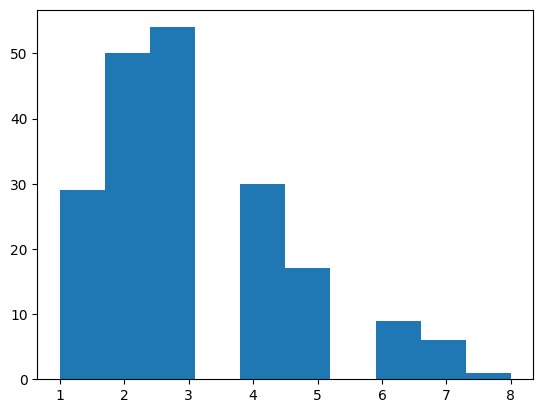

In [17]:
plt.hist(test['sign'].value_counts())

In [18]:
import concurrent.futures
from tqdm import tqdm

def process_video_sequential(video_path_df):
    # Initialize a list to store the results
    results = []

    # Create a progress bar
    progress_bar = tqdm(total=len(video_path_df), desc="Processing videos")

    # Iterate over the video paths
    for video_path in video_path_df:
        # Process the video and store the result
        process_video_to_landmarks_json(video_path, json_output=True, show_preview=False, save_annotated_video=False, frame_interval=1, rear_camera=True, skip_existing=True)

        # Update the progress bar
        progress_bar.update(1)


In [19]:
process_video_sequential(test.video_path)

Processing videos:   5%|█████▌                                                                                                        | 30/600 [00:00<00:03, 145.94it/s]

Skipping video '39839' as landmarks file already exists.
Skipping video '63214' as landmarks file already exists.
Skipping video '62506' as landmarks file already exists.
Skipping video '65983' as landmarks file already exists.
Skipping video '66820' as landmarks file already exists.
Skipping video '69470' as landmarks file already exists.
Skipping video '46266' as landmarks file already exists.
Skipping video '22113' as landmarks file already exists.
Skipping video '03002' as landmarks file already exists.
Skipping video '27173' as landmarks file already exists.
Skipping video '34580' as landmarks file already exists.
Skipping video '08937' as landmarks file already exists.
Skipping video '17832' as landmarks file already exists.
Skipping video '25686' as landmarks file already exists.
Skipping video '17724' as landmarks file already exists.
Skipping video '39951' as landmarks file already exists.
Skipping video '05661' as landmarks file already exists.
Skipping video '26174' as landm

Processing videos:   6%|██████▌                                                                                                       | 36/600 [00:14<00:03, 145.94it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/48983_landmarks.json'


Processing videos:   6%|██████▊                                                                                                        | 37/600 [00:20<07:50,  1.20it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/06845_landmarks.json'
Skipping video '54998' as landmarks file already exists.


Processing videos:   6%|███████▏                                                                                                       | 39/600 [00:29<10:56,  1.17s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/03001_landmarks.json'
Skipping video '04873' as landmarks file already exists.
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/07943_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/34746_landmarks.json'
Skipping video '17083' as landmarks file already exists.


Processing videos:   7%|████████▏                                                                                                      | 44/600 [00:46<16:35,  1.79s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/60460_landmarks.json'


Processing videos:   8%|████████▎                                                                                                      | 45/600 [00:52<19:27,  2.10s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/14452_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/62930_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/26779_landmarks.json'


Processing videos:   8%|████████▉                                                                                                      | 48/600 [01:05<24:17,  2.64s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66781_landmarks.json'


Processing videos:   8%|█████████                                                                                                      | 49/600 [01:12<28:19,  3.08s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/26158_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/63203_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/69533_landmarks.json'


Processing videos:   9%|█████████▌                                                                                                     | 52/600 [01:25<31:01,  3.40s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/42231_landmarks.json'


Processing videos:  11%|████████████▌                                                                                                  | 68/600 [01:27<07:54,  1.12it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/27153_landmarks.json'
Skipping video '32326' as landmarks file already exists.
Skipping video '66561' as landmarks file already exists.
Skipping video '20636' as landmarks file already exists.
Skipping video '08514' as landmarks file already exists.
Skipping video '43220' as landmarks file already exists.
Skipping video '27406' as landmarks file already exists.
Skipping video '03342' as landmarks file already exists.
Skipping video '24614' as landmarks file already exists.
Skipping video '23628' as landmarks file already exists.
Skipping video '51504' as landmarks file already exists.
Skipping video '14177' as landmarks file already exists.
Skipping video '48043' as landmarks file already exists.
Skipping video '34584' as landmarks file already exists.
Skipping video '38525' as landmarks file already exists.
Skipping video '49182' as landmarks file already exists.
Skipping video '59555' as 

Processing videos:  13%|██████████████▌                                                                                                | 79/600 [01:27<04:25,  1.96it/s]

Skipping video '51340' as landmarks file already exists.
Skipping video '06794' as landmarks file already exists.
Skipping video '65125' as landmarks file already exists.
Skipping video '40465' as landmarks file already exists.


Processing videos:  14%|████████████████                                                                                               | 87/600 [01:39<06:50,  1.25it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05654_landmarks.json'
Skipping video '06789' as landmarks file already exists.
Skipping video '14174' as landmarks file already exists.
Skipping video '52354' as landmarks file already exists.
Skipping video '24581' as landmarks file already exists.
Skipping video '66774' as landmarks file already exists.
Skipping video '58807' as landmarks file already exists.
Skipping video '07068' as landmarks file already exists.
Skipping video '66644' as landmarks file already exists.


Processing videos:  15%|████████████████▊                                                                                              | 91/600 [01:45<08:04,  1.05it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/04715_landmarks.json'
Skipping video '34732' as landmarks file already exists.
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/06833_landmarks.json'
Skipping video '01991' as landmarks file already exists.
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/28107_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/34825_landmarks.json'


Processing videos:  16%|█████████████████▉                                                                                             | 97/600 [02:06<13:54,  1.66s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/45760_landmarks.json'
Skipping video '63204' as landmarks file already exists.


Processing videos:  16%|██████████████████▎                                                                                            | 99/600 [02:12<15:17,  1.83s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/40470_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/69219_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/21883_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/38534_landmarks.json'


Processing videos:  17%|██████████████████▉                                                                                           | 103/600 [02:29<19:57,  2.41s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/52316_landmarks.json'


Processing videos:  17%|███████████████████                                                                                           | 104/600 [02:31<19:31,  2.36s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/22993_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66142_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/24941_landmarks.json'


Processing videos:  18%|███████████████████▌                                                                                          | 107/600 [02:48<26:46,  3.26s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/26715_landmarks.json'


Processing videos:  20%|██████████████████████▏                                                                                       | 121/600 [02:53<08:59,  1.13s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/04708_landmarks.json'
Skipping video '25515' as landmarks file already exists.
Skipping video '60576' as landmarks file already exists.
Skipping video '26006' as landmarks file already exists.
Skipping video '26719' as landmarks file already exists.
Skipping video '56971' as landmarks file already exists.
Skipping video '57974' as landmarks file already exists.
Skipping video '58902' as landmarks file already exists.
Skipping video '25685' as landmarks file already exists.
Skipping video '21100' as landmarks file already exists.
Skipping video '18773' as landmarks file already exists.
Skipping video '06788' as landmarks file already exists.
Skipping video '65728' as landmarks file already exists.
Skipping video '64263' as landmarks file already exists.
Skipping video '52862' as landmarks file already exists.
Skipping video '69413' as landmarks file already exists.
Skipping video '52324' as 

Processing videos:  24%|██████████████████████████▉                                                                                   | 147/600 [02:53<02:37,  2.88it/s]

Skipping video '22085' as landmarks file already exists.
Skipping video '63201' as landmarks file already exists.
Skipping video '22746' as landmarks file already exists.
Skipping video '21874' as landmarks file already exists.
Skipping video '34091' as landmarks file already exists.
Skipping video '26009' as landmarks file already exists.
Skipping video '36858' as landmarks file already exists.
Skipping video '48510' as landmarks file already exists.
Skipping video '33465' as landmarks file already exists.
Skipping video '21870' as landmarks file already exists.
Skipping video '34830' as landmarks file already exists.
Skipping video '69536' as landmarks file already exists.
Skipping video '69479' as landmarks file already exists.
Skipping video '01422' as landmarks file already exists.
Skipping video '14568' as landmarks file already exists.
Skipping video '51329' as landmarks file already exists.
Skipping video '40116' as landmarks file already exists.
Skipping video '43219' as landm

Processing videos:  29%|███████████████████████████████▌                                                                              | 172/600 [02:53<01:05,  6.58it/s]

Skipping video '63283' as landmarks file already exists.
Skipping video '24582' as landmarks file already exists.
Skipping video '40129' as landmarks file already exists.
Skipping video '27999' as landmarks file already exists.
Skipping video '20700' as landmarks file already exists.
Skipping video '09307' as landmarks file already exists.
Skipping video '32320' as landmarks file already exists.
Skipping video '14572' as landmarks file already exists.
Skipping video '54557' as landmarks file already exists.
Skipping video '48973' as landmarks file already exists.
Skipping video '17823' as landmarks file already exists.
Skipping video '69211' as landmarks file already exists.
Skipping video '23630' as landmarks file already exists.
Skipping video '50122' as landmarks file already exists.
Skipping video '62510' as landmarks file already exists.
Skipping video '54955' as landmarks file already exists.
Skipping video '37065' as landmarks file already exists.
Skipping video '36863' as landm

Processing videos:  33%|████████████████████████████████████▋                                                                         | 200/600 [02:54<00:27, 14.69it/s]

Skipping video '69395' as landmarks file already exists.
Skipping video '17428' as landmarks file already exists.
Skipping video '46733' as landmarks file already exists.
Skipping video '54764' as landmarks file already exists.
Skipping video '58031' as landmarks file already exists.
Skipping video '09305' as landmarks file already exists.
Skipping video '40130' as landmarks file already exists.
Skipping video '27417' as landmarks file already exists.
Skipping video '02003' as landmarks file already exists.
Skipping video '66766' as landmarks file already exists.
Skipping video '65427' as landmarks file already exists.
Skipping video '43528' as landmarks file already exists.
Skipping video '24955' as landmarks file already exists.
Skipping video '49181' as landmarks file already exists.
Skipping video '04361' as landmarks file already exists.
Skipping video '49178' as landmarks file already exists.
Skipping video '26698' as landmarks file already exists.
Skipping video '49658' as landm

Processing videos:  38%|█████████████████████████████████████████▉                                                                    | 229/600 [02:54<00:12, 28.57it/s]

Skipping video '52348' as landmarks file already exists.
Skipping video '60459' as landmarks file already exists.
Skipping video '07963' as landmarks file already exists.
Skipping video '66328' as landmarks file already exists.
Skipping video '21891' as landmarks file already exists.
Skipping video '32094' as landmarks file already exists.
Skipping video '08510' as landmarks file already exists.
Skipping video '51058' as landmarks file already exists.
Skipping video '28003' as landmarks file already exists.
Skipping video '36780' as landmarks file already exists.
Skipping video '37040' as landmarks file already exists.
Skipping video '04870' as landmarks file already exists.
Skipping video '09533' as landmarks file already exists.
Skipping video '63284' as landmarks file already exists.
Skipping video '57832' as landmarks file already exists.
Skipping video '60579' as landmarks file already exists.
Skipping video '56820' as landmarks file already exists.
Skipping video '21855' as landm

Processing videos:  43%|███████████████████████████████████████████████▍                                                              | 259/600 [02:54<00:06, 49.93it/s]

Skipping video '07070' as landmarks file already exists.
Skipping video '66643' as landmarks file already exists.
Skipping video '05728' as landmarks file already exists.
Skipping video '69317' as landmarks file already exists.
Skipping video '64281' as landmarks file already exists.
Skipping video '51503' as landmarks file already exists.
Skipping video '06002' as landmarks file already exists.
Skipping video '06334' as landmarks file already exists.
Skipping video '01724' as landmarks file already exists.
Skipping video '60574' as landmarks file already exists.
Skipping video '56978' as landmarks file already exists.
Skipping video '52867' as landmarks file already exists.
Skipping video '20634' as landmarks file already exists.
Skipping video '66740' as landmarks file already exists.
Skipping video '65668' as landmarks file already exists.
Skipping video '13696' as landmarks file already exists.
Skipping video '42966' as landmarks file already exists.
Skipping video '05682' as landm

Processing videos:  48%|█████████████████████████████████████████████████████▏                                                        | 290/600 [02:54<00:04, 74.47it/s]

Skipping video '69239' as landmarks file already exists.
Skipping video '06477' as landmarks file already exists.
Skipping video '48050' as landmarks file already exists.
Skipping video '39635' as landmarks file already exists.
Skipping video '65540' as landmarks file already exists.
Skipping video '24583' as landmarks file already exists.
Skipping video '66709' as landmarks file already exists.
Skipping video '64305' as landmarks file already exists.
Skipping video '05629' as landmarks file already exists.
Skipping video '05742' as landmarks file already exists.
Skipping video '17582' as landmarks file already exists.
Skipping video '33286' as landmarks file already exists.
Skipping video '45759' as landmarks file already exists.
Skipping video '14566' as landmarks file already exists.
Skipping video '10587' as landmarks file already exists.
Skipping video '32325' as landmarks file already exists.
Skipping video '69302' as landmarks file already exists.
Skipping video '66562' as landm

Processing videos:  54%|██████████████████████████████████████████████████████████▍                                                  | 322/600 [02:55<00:02, 103.28it/s]

Skipping video '59548' as landmarks file already exists.
Skipping video '66552' as landmarks file already exists.
Skipping video '26942' as landmarks file already exists.
Skipping video '69510' as landmarks file already exists.
Skipping video '08107' as landmarks file already exists.
Skipping video '33454' as landmarks file already exists.
Skipping video '37612' as landmarks file already exists.
Skipping video '28379' as landmarks file already exists.
Skipping video '40121' as landmarks file already exists.
Skipping video '02826' as landmarks file already exists.
Skipping video '02999' as landmarks file already exists.
Skipping video '24589' as landmarks file already exists.
Skipping video '34839' as landmarks file already exists.
Skipping video '43222' as landmarks file already exists.
Skipping video '51064' as landmarks file already exists.
Skipping video '21941' as landmarks file already exists.
Skipping video '42239' as landmarks file already exists.
Skipping video '66015' as landm

Processing videos:  60%|█████████████████████████████████████████████████████████████████▏                                           | 359/600 [02:55<00:01, 136.70it/s]

Skipping video '34827' as landmarks file already exists.
Skipping video '10453' as landmarks file already exists.
Skipping video '64306' as landmarks file already exists.
Skipping video '52617' as landmarks file already exists.
Skipping video '08942' as landmarks file already exists.
Skipping video '63287' as landmarks file already exists.
Skipping video '17091' as landmarks file already exists.
Skipping video '28377' as landmarks file already exists.
Skipping video '52623' as landmarks file already exists.
Skipping video '11037' as landmarks file already exists.
Skipping video '26946' as landmarks file already exists.
Skipping video '14477' as landmarks file already exists.
Skipping video '25687' as landmarks file already exists.
Skipping video '66767' as landmarks file already exists.
Skipping video '36791' as landmarks file already exists.
Skipping video '46737' as landmarks file already exists.
Skipping video '38337' as landmarks file already exists.
Skipping video '66822' as landm

Processing videos:  63%|████████████████████████████████████████████████████████████████████▎                                        | 376/600 [02:55<00:01, 137.86it/s]

Skipping video '34370' as landmarks file already exists.
Skipping video '22548' as landmarks file already exists.
Skipping video '69258' as landmarks file already exists.
Skipping video '34087' as landmarks file already exists.
Skipping video '57827' as landmarks file already exists.
Skipping video '20699' as landmarks file already exists.
Skipping video '63280' as landmarks file already exists.
Skipping video '40477' as landmarks file already exists.
Skipping video '51331' as landmarks file already exists.
Skipping video '52349' as landmarks file already exists.
Skipping video '06839' as landmarks file already exists.
Skipping video '22558' as landmarks file already exists.
Skipping video '66415' as landmarks file already exists.
Skipping video '33269' as landmarks file already exists.
Skipping video '22996' as landmarks file already exists.
Skipping video '10447' as landmarks file already exists.
Skipping video '17589' as landmarks file already exists.
Skipping video '59058' as landm

Processing videos:  68%|█████████████████████████████████████████████████████████████████████████▉                                   | 407/600 [02:55<00:01, 123.72it/s]

Skipping video '05732' as landmarks file already exists.
Skipping video '36046' as landmarks file already exists.
Skipping video '69460' as landmarks file already exists.
Skipping video '11036' as landmarks file already exists.
Skipping video '38524' as landmarks file already exists.
Skipping video '69206' as landmarks file already exists.
Skipping video '21863' as landmarks file already exists.
Skipping video '65354' as landmarks file already exists.
Skipping video '11034' as landmarks file already exists.
Skipping video '60907' as landmarks file already exists.
Skipping video '58447' as landmarks file already exists.
Skipping video '69360' as landmarks file already exists.
Skipping video '46732' as landmarks file already exists.
Skipping video '42961' as landmarks file already exists.
Skipping video '52686' as landmarks file already exists.
Skipping video '17933' as landmarks file already exists.
Skipping video '46272' as landmarks file already exists.
Skipping video '69545' as landm

Processing videos:  72%|███████████████████████████████████████████████████████████████████████████████                              | 435/600 [02:55<00:01, 121.70it/s]

Skipping video '41907' as landmarks file already exists.
Skipping video '58503' as landmarks file already exists.
Skipping video '69213' as landmarks file already exists.
Skipping video '48044' as landmarks file already exists.
Skipping video '21187' as landmarks file already exists.
Skipping video '37063' as landmarks file already exists.
Skipping video '05638' as landmarks file already exists.
Skipping video '63653' as landmarks file already exists.
Skipping video '36605' as landmarks file already exists.
Skipping video '42969' as landmarks file already exists.
Skipping video '38861' as landmarks file already exists.
Skipping video '26166' as landmarks file already exists.
Skipping video '09235' as landmarks file already exists.
Skipping video '45994' as landmarks file already exists.
Skipping video '36606' as landmarks file already exists.
Skipping video '39841' as landmarks file already exists.
Skipping video '34578' as landmarks file already exists.
Skipping video '56813' as landm

Processing videos:  78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 466/600 [02:56<00:01, 131.28it/s]

Skipping video '07937' as landmarks file already exists.
Skipping video '41905' as landmarks file already exists.
Skipping video '14180' as landmarks file already exists.
Skipping video '04718' as landmarks file already exists.
Skipping video '66656' as landmarks file already exists.
Skipping video '17932' as landmarks file already exists.
Skipping video '45912' as landmarks file already exists.
Skipping video '02010' as landmarks file already exists.
Skipping video '65721' as landmarks file already exists.
Skipping video '08944' as landmarks file already exists.
Skipping video '65544' as landmarks file already exists.
Skipping video '54554' as landmarks file already exists.
Skipping video '69342' as landmarks file already exists.
Skipping video '52320' as landmarks file already exists.
Skipping video '06787' as landmarks file already exists.
Skipping video '63205' as landmarks file already exists.
Skipping video '14466' as landmarks file already exists.
Skipping video '05688' as landm

Processing videos:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 480/600 [03:00<00:10, 11.22it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/09234_landmarks.json'
Skipping video '54567' as landmarks file already exists.
Skipping video '54966' as landmarks file already exists.
Skipping video '17828' as landmarks file already exists.
Skipping video '58806' as landmarks file already exists.
Skipping video '40469' as landmarks file already exists.
Skipping video '22553' as landmarks file already exists.


Processing videos:  82%|█████████████████████████████████████████████████████████████████████████████████████████▊                    | 490/600 [03:05<00:19,  5.59it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66365_landmarks.json'
Skipping video '63231' as landmarks file already exists.
Skipping video '17930' as landmarks file already exists.
Skipping video '65161' as landmarks file already exists.
Skipping video '48513' as landmarks file already exists.
Skipping video '05656' as landmarks file already exists.
Skipping video '22098' as landmarks file already exists.
Skipping video '25427' as landmarks file already exists.
Skipping video '52857' as landmarks file already exists.
Skipping video '66615' as landmarks file already exists.
Skipping video '05596' as landmarks file already exists.
Skipping video '63082' as landmarks file already exists.
Skipping video '48521' as landmarks file already exists.
Skipping video '69259' as landmarks file already exists.
Skipping video '54965' as landmarks file already exists.
Skipping video '44426' as landmarks file already exists.
Skipping video '46742' as 

Processing videos:  84%|███████████████████████████████████████████████████████████████████████████████████████████▊                  | 501/600 [03:11<00:27,  3.56it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/56830_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/48974_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/36782_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/09775_landmarks.json'


Processing videos:  84%|████████████████████████████████████████████████████████████████████████████████████████████▌                 | 505/600 [03:26<01:04,  1.46it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05599_landmarks.json'


Processing videos:  84%|████████████████████████████████████████████████████████████████████████████████████████████▊                 | 506/600 [03:31<01:23,  1.12it/s]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/28739_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/38858_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17712_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/64288_landmarks.json'


Processing videos:  85%|█████████████████████████████████████████████████████████████████████████████████████████████▌                | 510/600 [03:47<02:10,  1.45s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/19845_landmarks.json'


Processing videos:  85%|█████████████████████████████████████████████████████████████████████████████████████████████▋                | 511/600 [03:51<02:27,  1.65s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/08935_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/58895_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/16411_landmarks.json'


Processing videos:  86%|██████████████████████████████████████████████████████████████████████████████████████████████▏               | 514/600 [04:07<03:27,  2.41s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/11262_landmarks.json'


Processing videos:  86%|██████████████████████████████████████████████████████████████████████████████████████████████▍               | 515/600 [04:13<03:54,  2.76s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/09851_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/21951_landmarks.json'


Processing videos:  86%|██████████████████████████████████████████████████████████████████████████████████████████████▊               | 517/600 [04:21<04:09,  3.00s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65730_landmarks.json'
✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17820_landmarks.json'


Processing videos:  86%|███████████████████████████████████████████████████████████████████████████████████████████████▏              | 519/600 [04:35<05:19,  3.94s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/30832_landmarks.json'


Processing videos:  87%|███████████████████████████████████████████████████████████████████████████████████████████████▎              | 520/600 [04:40<05:27,  4.09s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/43218_landmarks.json'


Processing videos:  87%|███████████████████████████████████████████████████████████████████████████████████████████████▌              | 521/600 [04:43<05:00,  3.80s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/38999_landmarks.json'


Processing videos:  87%|███████████████████████████████████████████████████████████████████████████████████████████████▋              | 522/600 [04:47<05:11,  4.00s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/26531_landmarks.json'


Processing videos:  87%|███████████████████████████████████████████████████████████████████████████████████████████████▉              | 523/600 [04:54<05:49,  4.54s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/34733_landmarks.json'


Processing videos:  87%|████████████████████████████████████████████████████████████████████████████████████████████████              | 524/600 [05:00<06:07,  4.84s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/22549_landmarks.json'


Processing videos:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▎             | 525/600 [05:02<05:20,  4.27s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/38729_landmarks.json'


Processing videos:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▍             | 526/600 [05:07<05:28,  4.44s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/24609_landmarks.json'


Processing videos:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▌             | 527/600 [05:10<04:54,  4.04s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/63208_landmarks.json'


Processing videos:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▊             | 528/600 [05:13<04:20,  3.61s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/34579_landmarks.json'


Processing videos:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▉             | 529/600 [05:18<04:43,  4.00s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/56972_landmarks.json'


Processing videos:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏            | 530/600 [05:25<05:57,  5.11s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/54302_landmarks.json'


Processing videos:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎            | 531/600 [05:32<06:23,  5.56s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17146_landmarks.json'


Processing videos:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌            | 532/600 [05:37<06:13,  5.49s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/36860_landmarks.json'


Processing videos:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████▋            | 533/600 [05:44<06:25,  5.76s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17144_landmarks.json'


Processing videos:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████▉            | 534/600 [05:48<05:53,  5.36s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65187_landmarks.json'


Processing videos:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████            | 535/600 [05:51<05:03,  4.67s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/54766_landmarks.json'


Processing videos:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎           | 536/600 [05:57<05:29,  5.15s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/64264_landmarks.json'


Processing videos:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍           | 537/600 [06:03<05:30,  5.24s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/58445_landmarks.json'


Processing videos:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▋           | 538/600 [06:08<05:26,  5.27s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/19842_landmarks.json'


Processing videos:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████▊           | 539/600 [06:13<05:02,  4.96s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/06331_landmarks.json'


Processing videos:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 540/600 [06:18<05:03,  5.07s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/39006_landmarks.json'


Processing videos:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▏          | 541/600 [06:25<05:38,  5.74s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/07462_landmarks.json'


Processing videos:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎          | 542/600 [06:32<05:46,  5.97s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/11384_landmarks.json'


Processing videos:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌          | 543/600 [06:38<05:44,  6.04s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/11268_landmarks.json'


Processing videos:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋          | 544/600 [06:45<05:49,  6.23s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17733_landmarks.json'


Processing videos:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▉          | 545/600 [06:47<04:42,  5.14s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/20633_landmarks.json'


Processing videos:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████          | 546/600 [06:50<04:00,  4.44s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/02701_landmarks.json'


Processing videos:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 547/600 [06:56<04:22,  4.94s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/42958_landmarks.json'


Processing videos:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 548/600 [07:02<04:27,  5.15s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/06343_landmarks.json'


Processing videos:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 549/600 [07:07<04:29,  5.28s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/69330_landmarks.json'


Processing videos:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 550/600 [07:09<03:33,  4.27s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/38860_landmarks.json'


Processing videos:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████         | 551/600 [07:14<03:43,  4.56s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/09306_landmarks.json'


Processing videos:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 552/600 [07:20<03:52,  4.85s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/01986_landmarks.json'


Processing videos:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 553/600 [07:23<03:24,  4.35s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65485_landmarks.json'


Processing videos:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 554/600 [07:25<02:46,  3.63s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/54555_landmarks.json'


Processing videos:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 555/600 [07:32<03:26,  4.58s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/69311_landmarks.json'


Processing videos:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 556/600 [07:36<03:11,  4.35s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/28116_landmarks.json'


Processing videos:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████        | 557/600 [07:42<03:37,  5.06s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05727_landmarks.json'


Processing videos:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 558/600 [07:46<03:17,  4.70s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65179_landmarks.json'


Processing videos:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 559/600 [07:51<03:08,  4.59s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66599_landmarks.json'


Processing videos:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 560/600 [07:54<02:53,  4.33s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65850_landmarks.json'


Processing videos:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 561/600 [07:59<02:49,  4.34s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/24607_landmarks.json'


Processing videos:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████       | 562/600 [08:02<02:38,  4.17s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/27376_landmarks.json'


Processing videos:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 563/600 [08:08<02:45,  4.48s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05636_landmarks.json'


Processing videos:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 564/600 [08:12<02:38,  4.41s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/14175_landmarks.json'


Processing videos:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 565/600 [08:16<02:35,  4.45s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65079_landmarks.json'


Processing videos:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 566/600 [08:19<02:16,  4.02s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/36050_landmarks.json'
Skipping video '66778' as landmarks file already exists.


Processing videos:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 568/600 [08:23<01:34,  2.97s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65685_landmarks.json'


Processing videos:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 569/600 [08:27<01:41,  3.28s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/64291_landmarks.json'


Processing videos:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 570/600 [08:33<01:56,  3.90s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/51061_landmarks.json'
Skipping video '38336' as landmarks file already exists.


Processing videos:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 572/600 [08:38<01:31,  3.25s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/58450_landmarks.json'


Processing videos:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████     | 573/600 [08:43<01:43,  3.82s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/14451_landmarks.json'


Processing videos:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 574/600 [08:49<01:51,  4.28s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/16407_landmarks.json'


Processing videos:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 575/600 [08:52<01:36,  3.87s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/52317_landmarks.json'


Processing videos:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 576/600 [08:55<01:26,  3.61s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/32323_landmarks.json'


Processing videos:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 577/600 [09:04<02:03,  5.38s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/11287_landmarks.json'


Processing videos:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 578/600 [09:11<02:07,  5.79s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66098_landmarks.json'


Processing videos:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 579/600 [09:17<02:03,  5.90s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/39626_landmarks.json'


Processing videos:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 580/600 [09:22<01:48,  5.42s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/14183_landmarks.json'


Processing videos:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 581/600 [09:30<01:59,  6.27s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/42977_landmarks.json'


Processing videos:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 582/600 [09:38<02:00,  6.72s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/63285_landmarks.json'


Processing videos:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 583/600 [09:45<01:54,  6.71s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/19057_landmarks.json'


Processing videos:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████   | 584/600 [09:49<01:36,  6.01s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/27151_landmarks.json'


Processing videos:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 585/600 [09:53<01:22,  5.52s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/55808_landmarks.json'


Processing videos:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 586/600 [09:58<01:15,  5.40s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/09525_landmarks.json'


Processing videos:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 587/600 [10:01<00:58,  4.52s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/21099_landmarks.json'


Processing videos:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 588/600 [10:03<00:47,  3.97s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/24946_landmarks.json'


Processing videos:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 589/600 [10:09<00:49,  4.52s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/38868_landmarks.json'


Processing videos:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 590/600 [10:14<00:46,  4.67s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/28109_landmarks.json'


Processing videos:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 591/600 [10:19<00:42,  4.71s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65164_landmarks.json'


Processing videos:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 592/600 [10:26<00:41,  5.22s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/51056_landmarks.json'


Processing videos:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 593/600 [10:32<00:38,  5.44s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/58452_landmarks.json'


Processing videos:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 594/600 [10:35<00:29,  4.96s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/33268_landmarks.json'


Processing videos:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 595/600 [10:40<00:24,  4.99s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65506_landmarks.json'


Processing videos:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 596/600 [10:42<00:16,  4.11s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/22094_landmarks.json'


Processing videos: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 597/600 [10:45<00:10,  3.61s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/57677_landmarks.json'


Processing videos: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 598/600 [10:49<00:07,  3.62s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05740_landmarks.json'


Processing videos: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 599/600 [10:52<00:03,  3.69s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/26767_landmarks.json'


Processing videos: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [10:59<00:00,  1.10s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/52318_landmarks.json'
